In [26]:
# =============================================================================
# Environment and library versions
# =============================================================================
# This notebook was executed using the libraries listed below.
# Versions are recorded to ensure reproducibility of experiments.
# =============================================================================

import sys
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import qiskit
import qiskit_machine_learning
import qiskit_algorithms

print("Python version:")
print(sys.version)
print()

print("Core libraries:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print()

print("Machine learning:")
print("scikit-learn:", sklearn.__version__)
print()

print("Quantum computing:")
print("qiskit:", qiskit.__version__)
print("qiskit-machine-learning:", qiskit_machine_learning.__version__)
print("qiskit-algorithms:", qiskit_algorithms.__version__)

Python version:
3.11.14 (main, Oct 21 2025, 18:27:30) [Clang 20.1.8 ]

Core libraries:
numpy: 2.4.1
pandas: 2.3.3
matplotlib: 3.10.8
seaborn: 0.13.2

Machine learning:
scikit-learn: 1.8.0

Quantum computing:
qiskit: 2.3.0
qiskit-machine-learning: 0.9.0
qiskit-algorithms: 0.4.0


## 4. Data Design

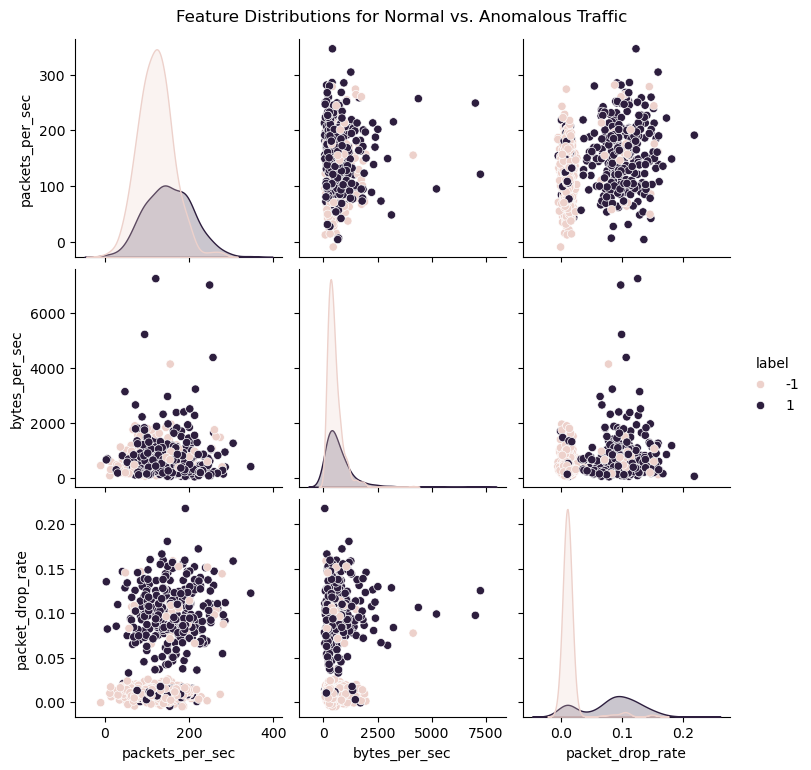

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)

def generate_network_traffic_data(n_samples=1000, anomaly_ratio=0.5):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous
    
    # Normal traffic
    normal_packets = np.random.normal(loc=100, scale=10, size=n_normal)
    normal_bytes = normal_packets * np.random.normal(loc=10, scale=2, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
#     normal_protocol = np.random.choice([1], size=n_normal) # TCP only
    
    # Anomalous traffic
    anomaly_packets = np.random.normal(loc=300, scale=40, size=n_anomalous)
    anomaly_bytes = anomaly_packets * np.random.normal(loc=15, scale=5, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
#     anomaly_protocol = np.random.choice([2,3], size=n_anomalous) # sudden protocol change (e.g. UDP, ICMP)
    
    X = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate))
    ])
    
    y = np.array([-1]*n_normal + [1]*n_anomalous)
    
    return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate"]), y

def generate_network_traffic_data_2(n_samples=1000, anomaly_ratio=0.05):
    n_anomalous = int(n_samples * anomaly_ratio)
    n_normal = n_samples - n_anomalous
    
    # Normal traffic
    normal_packets  = np.random.normal(120, 40, n_normal)
    normal_bytes = np.random.lognormal(mean=6, sigma=0.6, size=n_normal)
    normal_drop_rate = np.random.normal(loc=0.01, scale=0.005, size=n_normal)
#     normal_protocol = np.random.choice([1], size=n_normal) # TCP only
    
    # Anomalous traffic
    anomaly_packets = np.random.normal(160, 60, n_anomalous)
    anomaly_bytes = np.random.lognormal(mean=6.2, sigma=0.9, size=n_anomalous)
    anomaly_drop_rate = np.random.normal(loc=0.1, scale=0.03, size=n_anomalous)
#     anomaly_protocol = np.random.choice([2,3], size=n_anomalous) # sudden protocol change (e.g. UDP, ICMP)
    
    X = np.vstack([
        np.column_stack((normal_packets, normal_bytes, normal_drop_rate)),
        np.column_stack((anomaly_packets, anomaly_bytes, anomaly_drop_rate))
    ])
    
    y = np.array([-1]*n_normal + [1]*n_anomalous)
    flip_idx = np.random.choice(len(y), size=int(0.1*len(y)), replace=False)
    y[flip_idx] *= -1
    
    return pd.DataFrame(X, columns=["packets_per_sec", "bytes_per_sec", "packet_drop_rate"]), y

X_df, y = generate_network_traffic_data_2(n_samples=1000, anomaly_ratio=0.3)

sns.pairplot(pd.DataFrame(X_df).assign(label=y), hue="label", diag_kind="kde")
plt.suptitle("Feature Distributions for Normal vs. Anomalous Traffic", y=1.02)
plt.show()

## 5. Preprocessing Pipeline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Training and Optimizer Monitoring

### A. First Quantum Model: ZZFeatureMap + RealAmplitudes + COBYLA

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/807803665.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement="linear")
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/807803665.py:5: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=3, reps=2, entanglement="linear")


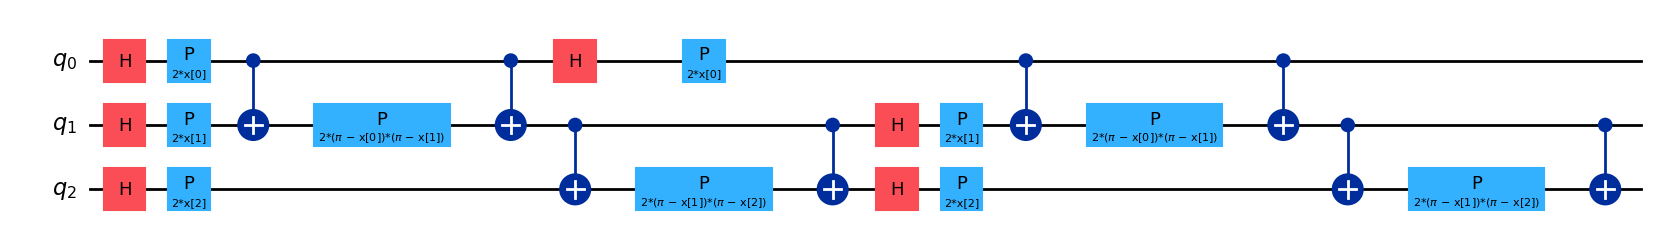

In [3]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# Feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement="linear")
ansatz = RealAmplitudes(num_qubits=3, reps=2, entanglement="linear")

#Visualize circuits
feature_map.decompose().draw('mpl')

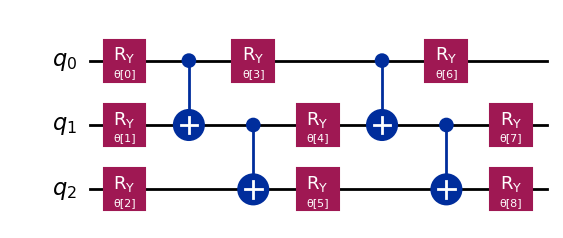

In [4]:
ansatz.decompose().draw('mpl')

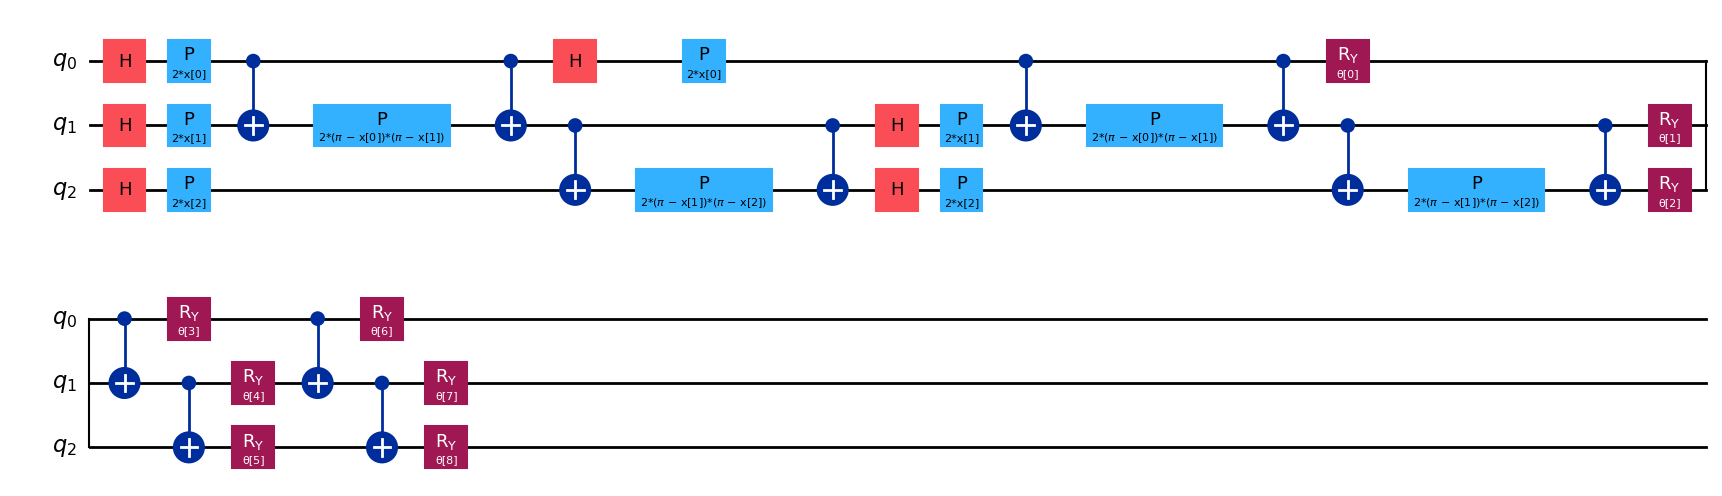

In [5]:
from qiskit import QuantumCircuit
# =========================
# Quantum Circuit
# =========================

qc = QuantumCircuit(3)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qc.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 38.58 seconds
Loss values recorded: 0


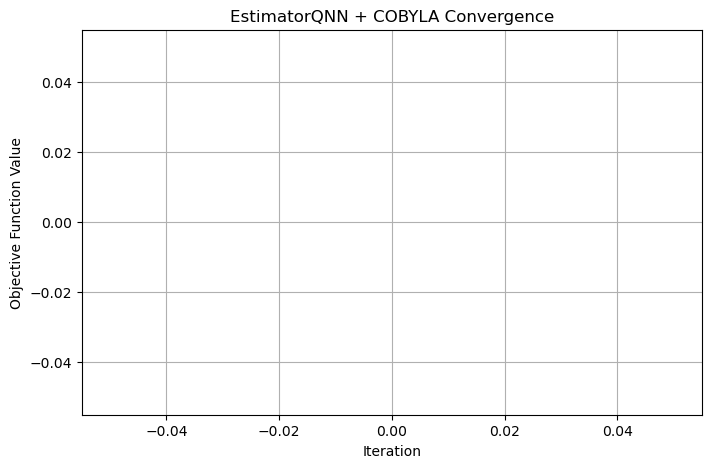

In [6]:
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
import time

# =========================
# Setup
# =========================
np.random.seed(42)
loss_vals = []

objective_vals = []
def clf_callback(*args):
    if len(args) == 2:
        weights, objective = args
        print(f"Loss = {objective:.6f}", flush=True)
        objective_vals.append(objective)
    elif len(args) == 1:
        (weights,) = args
        print("Callback got weights only (no objective).", flush=True)
    else:
        print(f"Callback got unexpected args: {len(args)}", flush=True)
        

# ✅ THIS CALLBACK *WILL* BE CALLED
# def cobyla_callback(x):
#     print("Parameters:", x)

# =========================
# Estimator + QNN
# =========================
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer = COBYLA(
    maxiter=100,
#     callback=cobyla_callback
)

# =========================
# Classifier (WITH CALLBACK HERE)
# =========================
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    initial_point=np.random.uniform(-1, 1, qnn.num_weights),
    callback=clf_callback,
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end-start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8,5))
plt.plot(objective_vals, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + COBYLA Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-1)
Accuracy : 0.623
Precision: 0.549
Recall   : 0.538
F1 Score : 0.535


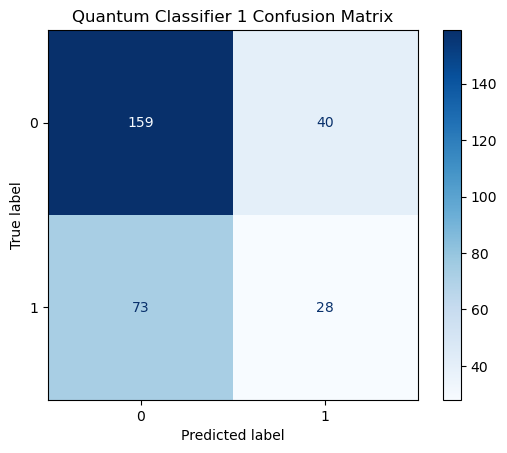


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# =========================
# PREDICTION
# =========================
y_pred = classifier.predict(X_test_scaled)
y_pred = np.asarray(y_pred)

# =========================
# METRICS (ROBUST)
# =========================
acc_1 = accuracy_score(y_test, y_pred)
prec_1 = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_1 = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-1)")
print(f"Accuracy : {acc_1:.3f}")
print(f"Precision: {prec_1:.3f}")
print(f"Recall   : {rec_1:.3f}")
print(f"F1 Score : {f1_1:.3f}")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title("Quantum Classifier 1 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred))

## B. Second Quantum Model: PauliFeatureMap + TwoLocal + SPSA

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/3828341189.py:5: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the pauli_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map_2 = PauliFeatureMap(feature_dimension=3, reps=2, paulis=['X', 'Y', 'Z'])
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/3828341189.py:6: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_2 = TwoLocal(num_qubits=3, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')


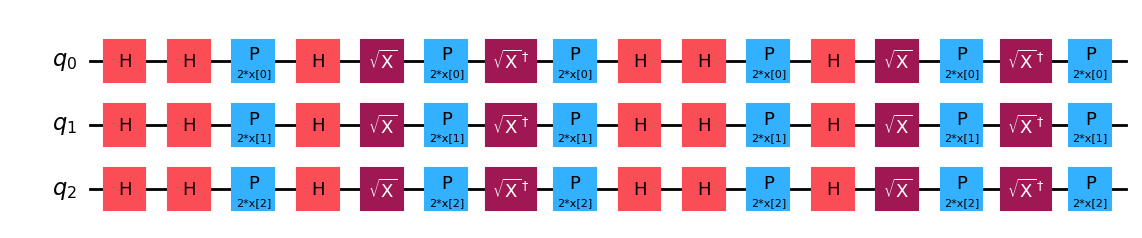

In [8]:
from qiskit.circuit.library import PauliFeatureMap, TwoLocal
from qiskit_algorithms.optimizers import SPSA

# Define the new feature map and ansatz
feature_map_2 = PauliFeatureMap(feature_dimension=3, reps=2, paulis=['X', 'Y', 'Z'])
ansatz_2 = TwoLocal(num_qubits=3, reps=2, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear')

# Visualize circuits
feature_map_2.decompose().draw('mpl')

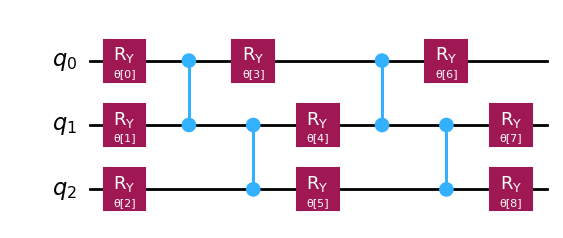

In [9]:
ansatz_2.decompose().draw('mpl')

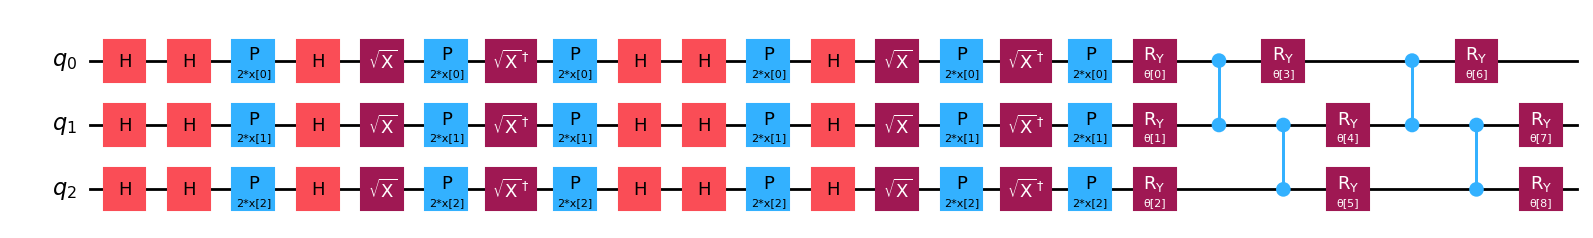

In [10]:
# =========================
# Quantum Circuit
# =========================

qc_2 = QuantumCircuit(3)
qc_2.compose(feature_map_2, inplace=True)
qc_2.compose(ansatz_2, inplace=True)

qc_2.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got unexpected args: 5
Callback got un

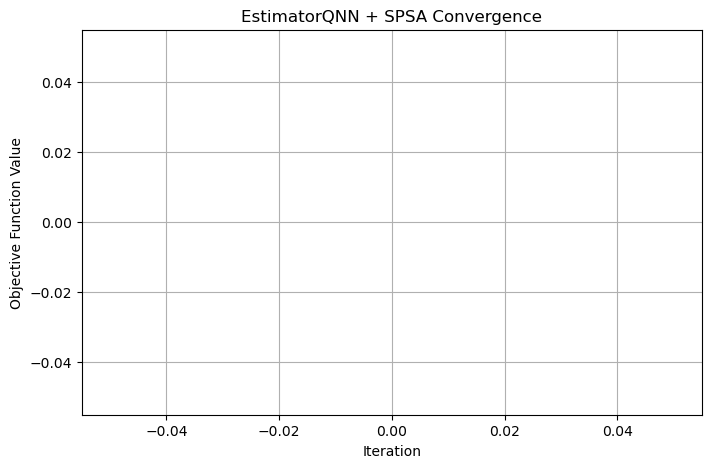

In [11]:
np.random.seed(42)
loss_vals_2 = []

def spsa_callback(nfev, params, value, stepsize, accepted):
    print(f"[{nfev:03}] Loss = {value:.6f}", flush=True)
    loss_vals_2.append(value)
    
# =========================
# Estimator + QNN (V2)
# =========================
estimator_2 = StatevectorEstimator()

qnn_2 = EstimatorQNN(
    circuit=qc_2,
    input_params=feature_map_2.parameters,
    weight_params=ansatz_2.parameters,
    estimator=estimator_2
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer_2 = SPSA(
    maxiter=100,
    callback=spsa_callback
)

classifier_2 = NeuralNetworkClassifier(
    neural_network=qnn_2,
    optimizer=optimizer_2,
    initial_point=np.random.uniform(-1, 1, qnn_2.num_weights),
    callback=clf_callback,
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier_2.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_2)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals_2, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + SPSA Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-2)
Accuracy : 0.663
Precision: 0.332
Recall   : 0.500
F1 Score : 0.399


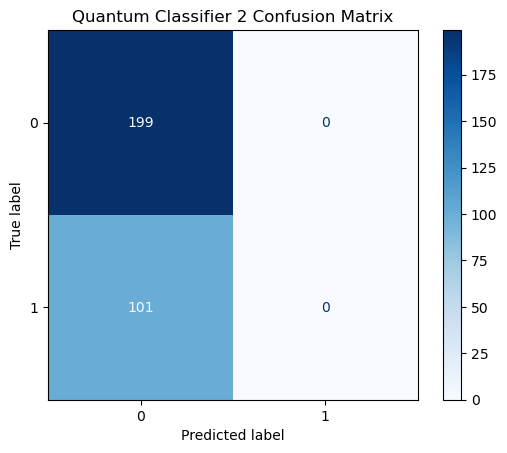


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.]


In [12]:
y_pred_2 = classifier_2.predict(X_test_scaled)
y_pred_2 = np.asarray(y_pred_2)

acc_2 = accuracy_score(y_test, y_pred_2)

prec_2 = precision_score(y_test, y_pred_2, average="macro", zero_division=0)
rec_2 = recall_score(y_test, y_pred_2, average="macro", zero_division=0)
f1_2 = f1_score(y_test, y_pred_2, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-2)")
print(f"Accuracy : {acc_2:.3f}")
print(f"Precision: {prec_2:.3f}")
print(f"Recall   : {rec_2:.3f}")
print(f"F1 Score : {f1_2:.3f}")

cm_2 = confusion_matrix(y_test, y_pred_2)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot(cmap="Blues", values_format="d")

plt.title("Quantum Classifier 2 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred_2))

## C. Third Quantum Model: ZFeatureMap + RealAmplitudes + ADAM

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/835126510.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map_3 = ZFeatureMap(feature_dimension=3, reps=2)
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/835126510.py:5: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz_3 = RealAmplitudes(num_qubits=3, reps=3, entanglement='linear')


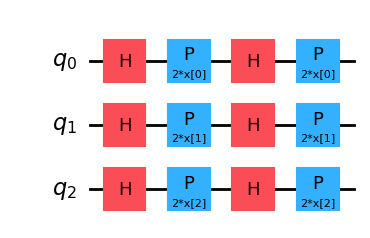

In [13]:
from qiskit.circuit.library import ZFeatureMap

# Define the new feature map and ansatz
feature_map_3 = ZFeatureMap(feature_dimension=3, reps=2)
ansatz_3 = RealAmplitudes(num_qubits=3, reps=3, entanglement='linear')

# Visualize circuits
feature_map_3.decompose().draw('mpl')

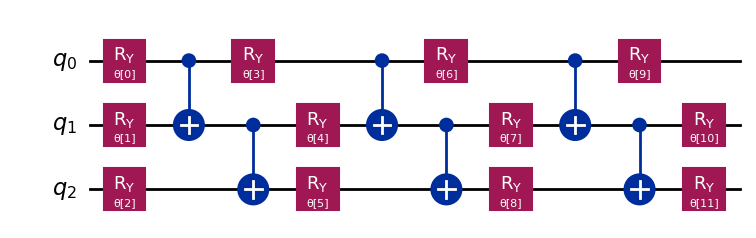

In [14]:
ansatz_3.decompose().draw('mpl')

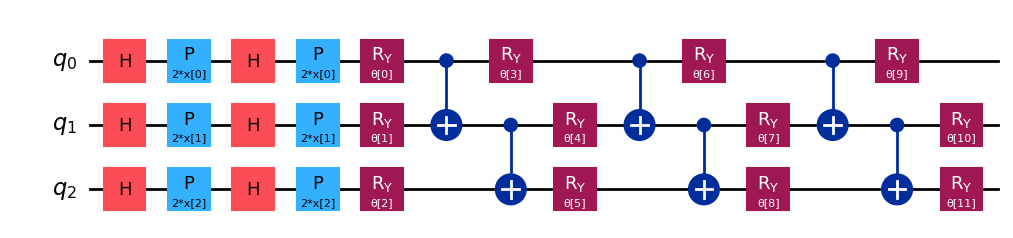

In [15]:
# =========================
# Quantum Circuit
# =========================

qc_3 = QuantumCircuit(3)
qc_3.compose(feature_map_3, inplace=True)
qc_3.compose(ansatz_3, inplace=True)

qc_3.decompose().draw('mpl')

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Training complete.
Elapsed time: 399.00 seconds
Loss values recorded: 0


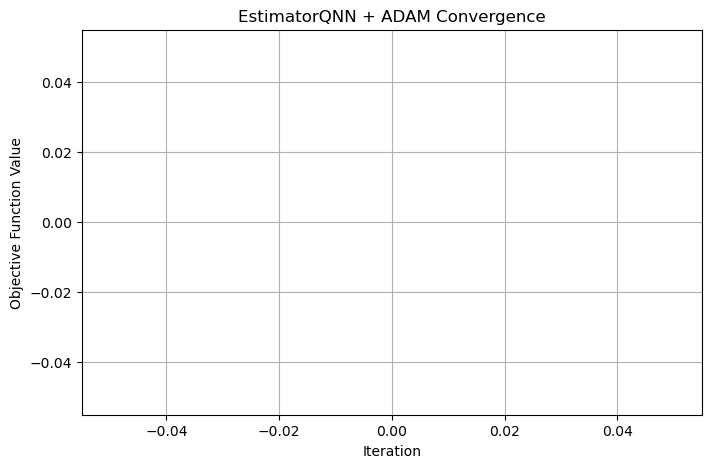

In [16]:
from qiskit_algorithms.optimizers import ADAM

np.random.seed(42)
loss_vals_3 = []

# def adam_callback(nfev, params, value, stepsize, accepted):
#     print(f"[{nfev:03}] Loss = {value:.6f}", flush=True)
#     loss_vals_2.append(value)
    
# =========================
# Estimator + QNN (V2)
# =========================
estimator_3 = StatevectorEstimator()

qnn_3 = EstimatorQNN(
    circuit=qc_3,
    input_params=feature_map_3.parameters,
    weight_params=ansatz_3.parameters,
    estimator=estimator_3
)

# =========================
# Optimizer (WITH CALLBACK)
# =========================
optimizer_3 = ADAM(maxiter=40, lr=0.1)

classifier_3 = NeuralNetworkClassifier(
    neural_network=qnn_3,
    optimizer=optimizer_3,
    initial_point=np.random.uniform(-1, 1, qnn_3.num_weights),
    callback=clf_callback,
)

# =========================
# Train
# =========================
print(">>> Starting training...")
start = time.time()

classifier_3.fit(X_train_scaled, y_train)

end = time.time()
print(">>> Training complete.")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_3)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals_3, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + ADAM Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-3)
Accuracy : 0.817
Precision: 0.847
Recall   : 0.742
F1 Score : 0.765


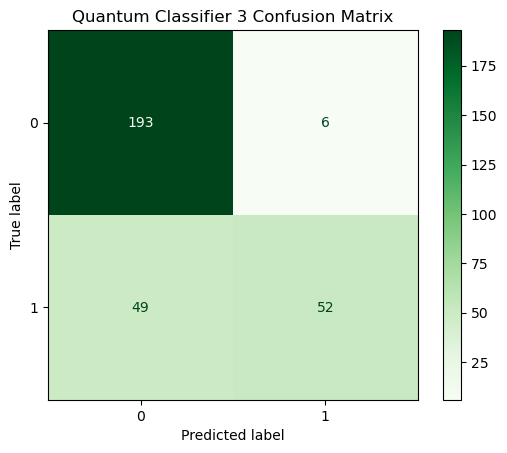


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [17]:
y_pred_3 = classifier_3.predict(X_test_scaled)
y_pred_3 = np.asarray(y_pred_3)

acc_3 = accuracy_score(y_test, y_pred_3)
prec_3 = precision_score(y_test, y_pred_3, average="macro", zero_division=0)
rec_3 = recall_score(y_test, y_pred_3, average="macro", zero_division=0)
f1_3 = f1_score(y_test, y_pred_3, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-3)")
print(f"Accuracy : {acc_3:.3f}")
print(f"Precision: {prec_3:.3f}")
print(f"Recall   : {rec_3:.3f}")
print(f"F1 Score : {f1_3:.3f}")

cm_3 = confusion_matrix(y_test, y_pred_3)

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp_3.plot(cmap="Greens", values_format="d")

plt.title("Quantum Classifier 3 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred_3))

got 100% accuracy using vqc-3, need to inspect target leakage lol

## D. Additional Quantum Experiment: Deeper Circuit (ZZFeatureMap + RealAmplitudes, reps=4)

/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/924665567.py:1: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map_4 = ZZFeatureMap(feature_dimension=3, reps=3, entanglement="linear")
/var/folders/ym/hfgzd_m5243fxb2vqkltvg580000gn/T/ipykernel_46363/924665567.py:2: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz_4 = RealAmplitudes(num_qubits=3, reps=3, entanglement="linear")


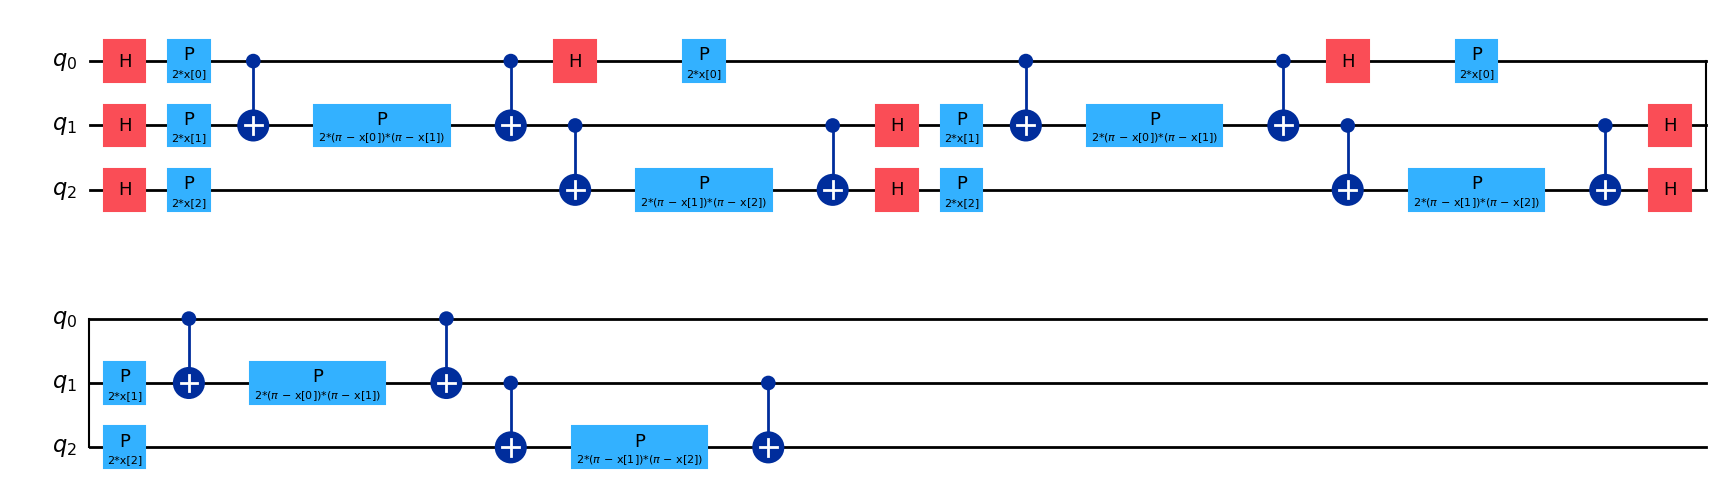

In [18]:
feature_map_4 = ZZFeatureMap(feature_dimension=3, reps=3, entanglement="linear")
ansatz_4 = RealAmplitudes(num_qubits=3, reps=3, entanglement="linear")

feature_map_4.decompose().draw('mpl')

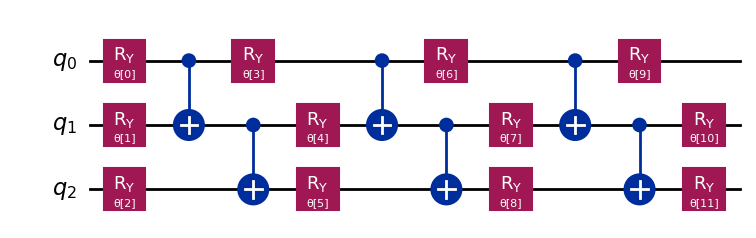

In [19]:
ansatz_4.decompose().draw('mpl')

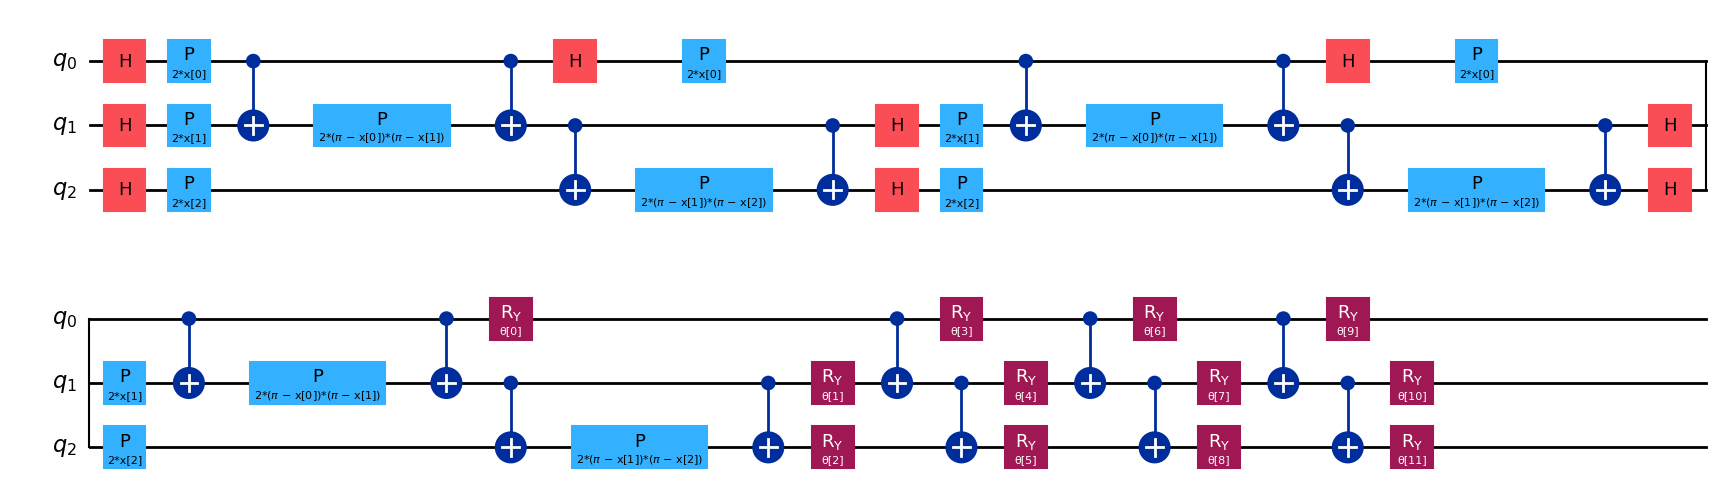

In [20]:
qc_4 = QuantumCircuit(3)
qc_4.compose(feature_map_4, inplace=True)
qc_4.compose(ansatz_4, inplace=True)

qc_4.decompose().draw("mpl")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


>>> Starting training...
>>> Complete training...
Elapsed time: 64.52 seconds
Loss values recorded: 0


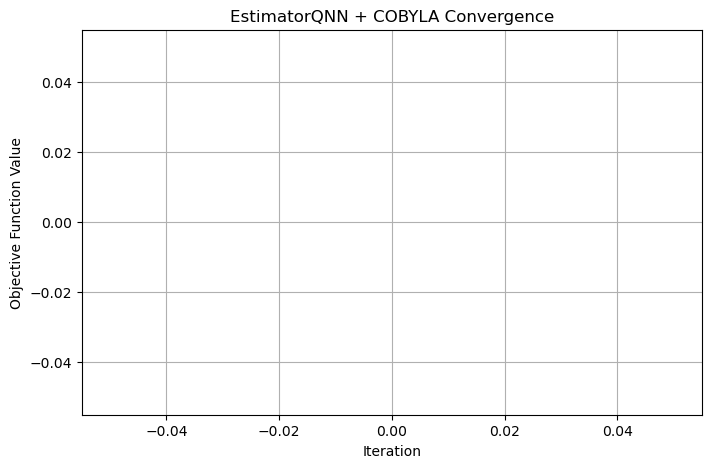

In [21]:
np.random.seed(42)
loss_vals_4 = []

estimator_4 = StatevectorEstimator()

qnn_4 = EstimatorQNN(
    circuit=qc_4,
    input_params=feature_map_4.parameters,
    weight_params=ansatz_4.parameters,
    estimator=estimator_4
)

optimizer_4 = COBYLA(
    maxiter=100,
)

classifier_4 = NeuralNetworkClassifier(
    neural_network=qnn_4,
    optimizer=optimizer_4,
    initial_point=np.random.uniform(-1,1, qnn_4.num_weights),
    callback=clf_callback,
)

print(">>> Starting training...")
start = time.time()

classifier_4.fit(X_train_scaled, y_train)

end = time.time()

print(">>> Complete training...")
print(f"Elapsed time: {end - start:.2f} seconds")
print(f"Loss values recorded: {len(loss_vals_4)}")

# =========================
# Plot
# =========================
plt.figure(figsize=(8, 5))
plt.plot(loss_vals_4, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("EstimatorQNN + COBYLA Convergence")
plt.grid(True)
plt.show()


▶ Evaluation Metrics (VQC-4)
Accuracy : 0.653
Precision: 0.596
Recall   : 0.580
F1 Score : 0.582


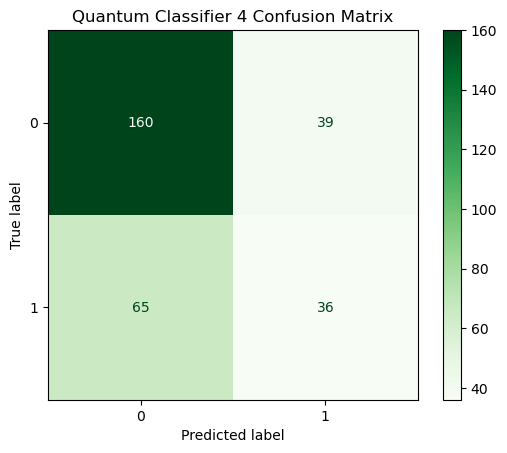


▶ Debug Info
Unique true labels : [-1  1]
Unique predicted labels: [-1.  1.]


In [22]:
y_pred_4 = classifier_4.predict(X_test_scaled)
y_pred_4 = np.asarray(y_pred_4)

acc_4 = accuracy_score(y_test, y_pred_4)
prec_4 = precision_score(y_test, y_pred_4, average="macro", zero_division=0)
rec_4 = recall_score(y_test, y_pred_4, average="macro", zero_division=0)
f1_4 = f1_score(y_test, y_pred_4, average="macro", zero_division=0)

print("\n▶ Evaluation Metrics (VQC-4)")
print(f"Accuracy : {acc_4:.3f}")
print(f"Precision: {prec_4:.3f}")
print(f"Recall   : {rec_4:.3f}")
print(f"F1 Score : {f1_4:.3f}")

cm_4 = confusion_matrix(y_test, y_pred_4)

disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4)
disp_4.plot(cmap="Greens", values_format="d")

plt.title("Quantum Classifier 4 Confusion Matrix")
plt.grid(False)
plt.show()

# =========================
# DEBUG (IMPORTANT)
# =========================
print("\n▶ Debug Info")
print("Unique true labels :", np.unique(y_test))
print("Unique predicted labels:", np.unique(y_pred_4))

## E. Classical Model Benchmark: SVM

SVM Metrics:
Accuracy: 0.903
Precision: 0.929
Recall: 0.772
F1 Score: 0.843


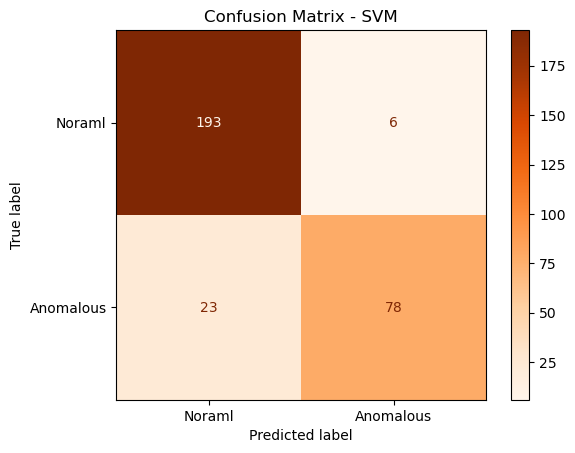

In [23]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Metrics:")
print(f"Accuracy: {acc_svm:.3f}")
print(f"Precision: {prec_svm:.3f}")
print(f"Recall: {rec_svm:.3f}")
print(f"F1 Score: {f1_svm:.3f}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Anomalous"])
disp_svm.plot(cmap="Oranges")
plt.title("Confusion Matrix - SVM")
plt.show()

## F. Classical Model Benchmark: Random Forest

Random Forest Metrics:
Accuracy: 0.907
Precision: 0.920
Recall: 0.792
F1 Score: 0.851


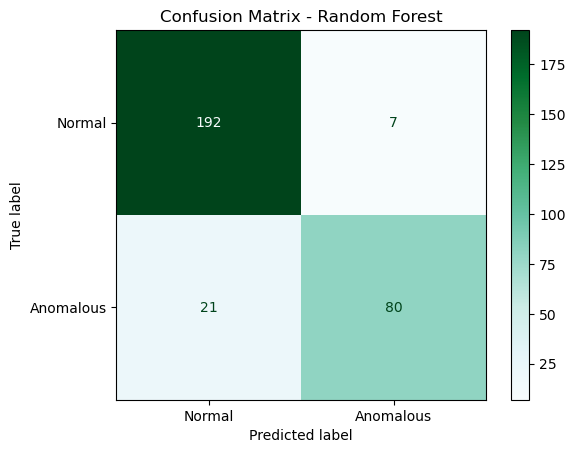

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Metrics:")
print(f"Accuracy: {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")
print(f"F1 Score: {f1_rf:.3f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Normal", "Anomalous"])
disp_rf.plot(cmap='BuGn')
plt.title("Confusion Matrix - Random Forest")
plt.show()

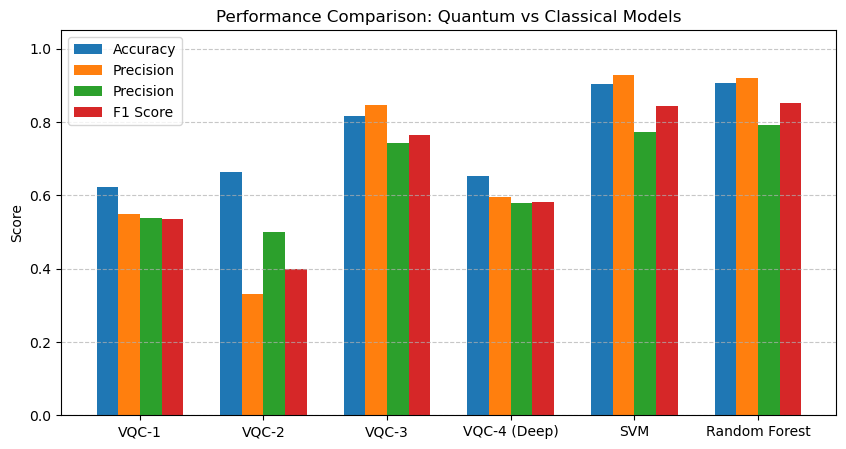

In [25]:
model_names = ["VQC-1", "VQC-2", "VQC-3", "VQC-4 (Deep)", "SVM", "Random Forest"]
accuracies = [acc_1, acc_2, acc_3, acc_4, acc_svm, acc_rf]
prec_scores = [prec_1, prec_2, prec_3, prec_4, prec_svm, prec_rf]
rec_scores = [rec_1, rec_2, rec_3, rec_4, rec_svm, rec_rf]
f1_scores = [f1_1, f1_2, f1_3, f1_4, f1_svm, f1_rf]

x = np.arange(0, len(model_names)*2, 2)
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - 3 * width/2, accuracies, width, label='Accuracy')
plt.bar(x - width/2, prec_scores, width, label='Precision')
plt.bar(x + width/2, rec_scores, width, label='Precision')
plt.bar(x + 3 * width/2, f1_scores, width, label='F1 Score')
plt.xticks(x, model_names)
plt.ylabel("Score")
plt.title("Performance Comparison: Quantum vs Classical Models")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()